# Определение популярных продуктов для рекламной кампании интернет-магазина

С помощью исторических данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах необходимо выявить определяющие успех игры факторы. Результаты анализа в дальнейшем будут использованы интернет-магазином при планировании рекламной кампании.

### Описание данных

- Name — название игры;
- Platform — платформа;
- Year_of_Release — год выпуска;
- Genre — жанр игры;
- NA_sales — продажи в Северной Америке (миллионы долларов);
- EU_sales — продажи в Европе (миллионы долларов);
- JP_sales — продажи в Японии (миллионы долларов);
- Other_sales — продажи в других странах (миллионы долларов);
- Critic_Score — оценка критиков (максимум 100);
- User_Score — оценка пользователей (максимум 10);
- Rating — рейтинг от организации ESRB.

### Библиотеки и модули

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy import stats as st

### Содержание

1. Изучение общей информации о данных
2. Подготовка данных
    - Изменение названия столбцов
    - Изменение типов данных
    - Работа с дубликатами
    - Работа с пропусками
    - Суммарные продажи в регионах
3. Исследовательский анализ данных (EDA)
    - Сколько игр выпускалось в разные годы
    - Как менялись продажи по платформам
    - Актуальный период
    - Потенциально прибыльные платформы
    - График «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам
    - Влияние отзывов пользовталей и критиков на продажи внутри одной популярной платформы
    - Справедлив ли вывод из пункта выше для других платформ?
    - Распределение игр и продаж по жанрам
4. Портер пользователя каждого региона (North America, Europe, Japan)
    - Портреты
    - Влияние рейтинга ESRB на продажи в регионах
5. Проверка гипотез
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    - Средние пользовательские рейтинги жанров Action и Sports разные
6. Общий вывод

## Изучение общей информации о данных

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные считались корректно.

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбцах: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating присутствуют пропуски. Также заметим, что столбец User_Score считался как тип object.

## Подготовка данных

### Изменение названия столбцов

Для придания стиля коду приведем все символы названий столбцов к нижнему регистру.

In [4]:
games_columns_lower = [column.lower() for column in games.columns.tolist()]
games_columns_lower

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

In [5]:
games.columns = games_columns_lower
games.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


### Изменение типов данных

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


1. К категориальному типа относятся следующие столбцы: name, platform, genre.  
2. К порядковому типу относятся следующие столбцы: rating.  
3. К количественному типу относятся следующие столбцы: 
    - непрерывные переменные: na_sales, eu_sales, jp_sales, other_sales
    - дискретные переменные: ctitic_score, user_score
4. К времененному типу данных относятся следующие столбцы: year_of_release.

Разберемся с тем, почему в столбце user_score тип данных object.

In [7]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.3       2
0.2       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Данный столбце имеет тип object, так как в нем хранится строковое значение tbd. Данное значение обозначает то, что рейтинг пользователи еще не выставили данной игре. Возможен случай того, что рейтинг пользователей в процессе подсчета, поэтому его нет, или собрано недостаточное количество оценок для того, чтобы выствить рейтинг игре со стороны пользователей. Объектов с данным значением признака 2424. Чтобы придать все-таки значение данному признаку, приравняем значение user_score к значению оценки, которую выставили критики (если оценка критиков заполнена каким-то числом, иначе значение tbd будет равно NaN). Приведем оценку критика к оценке пользователя, разделив оценку критику на 10.

In [8]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = games.loc[games['user_score'] == 'tbd', 'critic_score'] / 10
games['user_score'].value_counts()

7.8    324
8      290
8.2    282
8.3    254
8.5    253
      ... 
0        1
3.0      1
8.8      1
8.5      1
2.8      1
Name: user_score, Length: 160, dtype: int64

Приведем столбцы, тип которых не соответствует тому, который должен, к новому типу.

In [9]:
games['year_of_release'] = games['year_of_release'].fillna(0) # ставлю заглушку
games['year_of_release'] = games['year_of_release'].astype('int')

print(games['year_of_release'].dtypes)
games.head(5)

int64


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [10]:
games['user_score'] = pd.to_numeric(games['user_score'])
print(games['user_score'].dtypes)

float64


#### Оптимизация данных

In [11]:
"""
Функция для подсчета использования памяти каким-либо типом данных.
"""

def mem_usage(pd_obj):
    if isinstance(pd_obj, pd.DataFrame):
        usage_b = pd_obj.memory_usage(deep=True).sum()
    else:
        usage_b = pd_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2
    return "{:03.2f} MB".format(usage_mb)

Оптимизируем числовые типы

In [12]:
games_int = games.select_dtypes(include=['int']) # для данных типов int
converted_int = games_int.apply(pd.to_numeric, downcast='unsigned')

print(f'Было: {mem_usage(games_int)}')
print(f'Стало: {mem_usage(converted_int)}')

Было: 0.13 MB
Стало: 0.03 MB


In [13]:
games_float = games.select_dtypes(include=['float'])
converted_float = games_float.apply(pd.to_numeric, downcast='float')

print(f'Было: {mem_usage(games_float)}')
print(f'Стало: {mem_usage(converted_float)}')

Было: 0.77 MB
Стало: 0.38 MB


Оптимизировать категориальные не будем во избежание каких-либо проблем работы с данными.

Сохраним первоначальный датасет в отдельной переменной.

In [14]:
games_old = games
games = games_old.copy()

games[converted_int.columns] = converted_int
games[converted_float.columns] = converted_float

Посомотрим, как изменился объем памяти хранения данных.

In [15]:
print(f'Было: {mem_usage(games_old)}')
print(f'Стало: {mem_usage(games)}')

Было: 4.92 MB
Стало: 4.44 MB


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null uint16
genre              16713 non-null object
na_sales           16715 non-null float32
eu_sales           16715 non-null float32
jp_sales           16715 non-null float32
other_sales        16715 non-null float32
critic_score       8137 non-null float32
user_score         8672 non-null float32
rating             9949 non-null object
dtypes: float32(6), object(4), uint16(1)
memory usage: 946.9+ KB


### Работа с дубликатами

In [17]:
games.duplicated().sum()

0

Повторяющихся объектов в данной таблице нет.

In [18]:
games['name'].value_counts()

Need for Speed: Most Wanted                12
Madden NFL 07                               9
FIFA 14                                     9
Ratatouille                                 9
LEGO Marvel Super Heroes                    9
                                           ..
Dorabase DS: Dramatic Stadium               1
Sloane to MacHale no Nazo no Monogatari     1
Spider-Man: Battle for New York             1
Armored Core 2                              1
DX Game of Life                             1
Name: name, Length: 11559, dtype: int64

Имеются повторяющиеся названия игр, которые можно установить на разные платформы.

In [19]:
games['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

In [20]:
games['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [21]:
games['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
0        269
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

In [22]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [23]:
games['user_score'].value_counts()

7.8    343
8.0    296
8.2    287
7.5    273
7.0    262
      ... 
1.9      2
0.7      2
0.9      2
0.0      1
9.7      1
Name: user_score, Length: 95, dtype: int64

### Работа с пропусками

Выделяют три вида пропусков:
- MCAR - абсолютно случайные пропуски, вероятность появления которых одинакова для каждой записи набора данных.
- MAR - случайные пропуски, вероятность появления которых зависит от другой информации в данных.
- MNAR - неслучайные пропуски, вероятность появления которых зависит от другой информации в данных, при этом информация по этим атрибутам может отсутствовать.

Также пропуски разделяют по причине технологической и вызванной человеческим фактором.

In [24]:
games.isnull().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         8043
rating             6766
dtype: int64

In [25]:
(games.isnull().sum() / games.shape[0] * 100).sort_values(ascending=False)

critic_score       51.319174
user_score         48.118456
rating             40.478612
genre               0.011965
name                0.011965
other_sales         0.000000
jp_sales            0.000000
eu_sales            0.000000
na_sales            0.000000
year_of_release     0.000000
platform            0.000000
dtype: float64

*Столбец name*

In [26]:
games.query('name.isnull() == True')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что есть два объекта, данные о которых неизвестны не только по столбцу name, но и по столбца year_of_release, genre, ctitic_score, user_score, rating. Пропуски могли появится по причине, что при сборе данных данных по этим играм информации в источнике не было указано. Данный пропуск отнесем к типу MNAR. Поскольку всего два таких объекта, удаление их не скажется на результатах анализа данных. Этот способ также наиболее всего подходящий, так как восстановить пропуски не получится, особенно категориальные.

In [27]:
idx_delete_elements = games.query('name.isnull() == True').index
games.drop(idx_delete_elements, inplace=True)
games.query('name.isnull() == True')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


*Столбцы user_score, critic_score и rating*

Одна и та же игра на разных платформах будет иметь примерно один и тот же рейтинг и оценки пользователей и критиков на разных платформах. Такие пропуски возникли по причине тому, что данных вероятнее всего не было на какой-либо из платформ. Отнесем эти пропуски к типу MAR. Для заполнения пропусков создадим таблицу, в которой каждая игра будет хранить медианную оценку пользователей и критиков по всем платформам.

In [28]:
game_critic_user_score = games.pivot_table(index='name', values=['user_score', 'critic_score'], aggfunc='median')
game_critic_user_score.reset_index(inplace=True)
game_critic_user_score['critic_score'] = game_critic_user_score['critic_score'].round(1)
game_critic_user_score['user_score'] = game_critic_user_score['user_score'].round(1)
game_critic_user_score

,name,critic_score,user_score
0,Tales of Xillia 2,71.0,7.9
1,.hack//Infection Part 1,75.0,8.5
2,.hack//Mutation Part 2,76.0,8.9
3,.hack//Outbreak Part 3,70.0,8.7
4,007 Racing,51.0,4.6
...,...,...,...
5292,inFAMOUS: Second Son,80.0,7.9
5293,nail'd,65.0,6.6
5294,pro evolution soccer 2011,78.0,5.9
5295,uDraw Studio,71.0,7.1


In [29]:
game_critic_user_score.isnull().sum()

name              0
critic_score    212
user_score       20
dtype: int64

Видим, что в таблице есть пропущенные значения. Удалим те значения, где пропуски есть и в том, и в другом столбце.

In [30]:
game_critic_user_score.query('critic_score.isnull() == True and user_score.isnull() == True')

,name,critic_score,user_score


Таких значений нет. Приведем значения оценки пользователей к оценке критиков, умножив на 10, и приведем значения критиков к оценке пользователей, разделив на 10.

In [31]:
game_critic_user_score.loc[game_critic_user_score['user_score'].isnull() == True, 'user_score'] = game_critic_user_score.loc[game_critic_user_score['user_score'].isnull() == True, 'critic_score'] / 10
game_critic_user_score.loc[game_critic_user_score['critic_score'].isnull() == True, 'critic_score'] = game_critic_user_score.loc[game_critic_user_score['critic_score'].isnull() == True, 'user_score'] * 10
game_critic_user_score.isnull().sum()

name            0
critic_score    0
user_score      0
dtype: int64

In [32]:
unique_name_games = list(game_critic_user_score['name']) # вывожу список уникальных названий игр

Рейтинг для одной и той же игры не должен по сути отличаться, поэтому найдем значение моды по рейтингу для каждой игры по всем платформам.

In [33]:
"""
Функция, которая находит значение моды рейтинга для каждой игры (в случае если на разных платформах у нее стоит разный рейтинг).
"""

def mode_rating_for_game(row):
    try:
        name_game_row = row['name']
        mode_rating_for_game = games.loc[games['name'] == name_game_row, 'rating'].mode()[0]
        return mode_rating_for_game
    except:
        return 'no rating'

In [34]:
game_critic_user_score['rating'] = game_critic_user_score.apply(mode_rating_for_game, axis=1)
game_critic_user_score

,name,critic_score,user_score,rating
0,Tales of Xillia 2,71.0,7.9,T
1,.hack//Infection Part 1,75.0,8.5,T
2,.hack//Mutation Part 2,76.0,8.9,T
3,.hack//Outbreak Part 3,70.0,8.7,T
4,007 Racing,51.0,4.6,T
...,...,...,...,...
5292,inFAMOUS: Second Son,80.0,7.9,T
5293,nail'd,65.0,6.6,E10+
5294,pro evolution soccer 2011,78.0,5.9,E
5295,uDraw Studio,71.0,7.1,E


In [35]:
game_critic_user_score.query('rating == "no rating"').shape[0]

60

Имеем 60 объектов, рейтинг которых не определен.

In [36]:
"""
Функция, которая заполняет пропуски в столбце user_score,
используя информацию по оценкам пользователей об игре на других платформах.
"""

def fill_gapes_user_score(row):
    if row['user_score'] != row['user_score']:
        name_game_row = row['name']
        if name_game_row in unique_name_games:
            user_score_row = game_critic_user_score.query('name == @name_game_row')['user_score'].values[0]
            return user_score_row
    else:
        return row['user_score']

In [37]:
games['user_score'] = games.apply(fill_gapes_user_score, axis=1)
print(games['user_score'].isnull().sum())
games['user_score'].head(10)

7279


0    8.0
1    NaN
2    8.3
3    8.0
4    NaN
5    NaN
6    8.5
7    6.6
8    8.4
9    NaN
Name: user_score, dtype: float64

Количество пропусков в столбце user_score с помощью такого подхода удалось снизить примерно на 10%.

In [38]:
"""
Функция, которая заполняет пропуски в столбце critic_score,
используя информацию по оценкам критиков об игре на других платформах.
"""

def fill_gapes_critic_score(row):
    if row['critic_score'] != row['critic_score']:
        name_game_row = row['name']
        if name_game_row in unique_name_games:
            user_score_row = game_critic_user_score.query('name == @name_game_row')['critic_score'].values[0]
            return user_score_row
    else:
        return row['critic_score']

In [39]:
games['critic_score'] = games.apply(fill_gapes_critic_score, axis=1)
print(games['critic_score'].isnull().sum())
games['critic_score'].head(10)

7279


0    76.0
1     NaN
2    82.0
3    80.0
4     NaN
5     NaN
6    89.0
7    58.0
8    87.0
9     NaN
Name: critic_score, dtype: float64

Количество пропусков в столбце critic_score с помощью такого подхода удалось сократить примерно на 15%.

In [40]:
"""
Функция, которая заполняет пропуски в столбце rating,
используя информацию по рейтингу об игре на других платформах.
"""

def fill_gapes_rating(row):
    if row['rating'] != row['rating']:
        name_game_row = row['name']
        if name_game_row in unique_name_games:
            rating_row = game_critic_user_score.query('name == @name_game_row')['rating'].values[0]
            if rating_row != 'no rating':
                return rating_row
    else:
        return row['rating']

In [41]:
games['rating'] = games.apply(fill_gapes_rating, axis=1)
print(games['rating'].isnull().sum())
games['rating'].head(10)

6374


0       E
1    None
2       E
3       E
4    None
5    None
6       E
7       E
8       E
9    None
Name: rating, dtype: object

Количество пропусков в столбце rating с помощью такого подхода удалось сократить примерно на 5%.

Теперь попробуем понять то, какое количество объектов, где пропущены значения и в столбце user_score, и в столбце critic_score.

In [42]:
games.query('user_score.isnull() == True and critic_score.isnull() == True').shape[0]

7279

Таким образом, получаем 7279 объектов (это как раз то количество пропусков, которое у нас получилось выше и в том, и в другом столбцах) пропущены значения и в том, и в другом столбцах. Таких данных примерно 43% от общего числа объектов. Это не случайные пропуски. Данный тип пропусков отнесем к типу MNAR. Это достаточно большая доля, поэтому нужно подумать, как заполнить оставшиеся пропуски в столбцах critic_score и user_score.

In [43]:
games.query('critic_score.isnull() == True and user_score.isnull() == True')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.58,6.81,0.77,NaN,NaN,None
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.89,10.22,1.00,NaN,NaN,None
5,Tetris,GB,1989,Puzzle,23.200001,2.26,4.22,0.58,NaN,NaN,None
9,Duck Hunt,NES,1984,Shooter,26.930000,0.63,0.28,0.47,NaN,NaN,None
10,Nintendogs,DS,2005,Simulation,9.050000,10.95,1.93,2.74,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.000000,0.00,0.01,0.00,NaN,NaN,None
16711,LMA Manager 2007,X360,2006,Sports,0.000000,0.01,0.00,0.00,NaN,NaN,None
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.000000,0.00,0.01,0.00,NaN,NaN,None
16713,Spirits & Spells,GBA,2003,Platform,0.010000,0.00,0.00,0.00,NaN,NaN,None


Можно предположить, что игры, у которых пропущены значения в данных столбцах, содержат платформы менее востребованные, а поскольку у данных игр также нет ни рейтингов, ни оценок, то для пользователей они не обладют высоким спросом. Отсюда можно сделать вывод, что данные объекты мы можем спокойно исключить из нашего анализа.

In [44]:
delete_objects = games.query('critic_score.isnull() == True and user_score.isnull() == True').index.tolist()

In [45]:
games = games.drop(delete_objects)

In [46]:
print(f'Количество пропусков в столбце critic_score: {games["critic_score"].isnull().sum()}')
print(f'Количество пропусков в столбце user_score: {games["user_score"].isnull().sum()}')

Количество пропусков в столбце critic_score: 0
Количество пропусков в столбце user_score: 0


Остается рассмотреть пропущенные значения в столбце rating.

In [47]:
games['rating'].isnull().sum()

68

Отнесем данные пропуски к типу MAR, исходя из идеи о том, что то, какой рейтинг будет выставлены коррелирует с тем, какой жанр у игры.

In [48]:
genre_list = games['genre'].unique().tolist()

In [49]:
rating = []
for genre in genre_list:
    mode_for_genre = games.loc[games['genre'] == genre, 'rating'].mode()[0]
    rating.append(mode_for_genre)

In [50]:
genre_rating_df = pd.DataFrame({
    'genre': genre_list,
    'rating': rating
})
genre_rating_df

,genre,rating
0,Sports,E
1,Racing,E
2,Platform,E
3,Misc,E
4,Action,T
5,Puzzle,E
6,Shooter,M
7,Fighting,T
8,Simulation,T
9,Role-Playing,T


In [51]:
"""
Функция, которая заполняет пропущенные значения в столбце rating, используя значения из таблицы genre_rating_df.
"""

def fill_gaps_rating_2(row):
    if row['rating'] != None:
        return row['rating']
    else:
        genre_row = row['genre']
        new_rating_row = genre_rating_df.query('genre == @genre_row')['rating'].values[0]
        return new_rating_row

In [52]:
games['rating'] = games.apply(fill_gaps_rating_2, axis=1)
games['rating'].isnull().sum()

0

Посмотрим на то, какие и где пропуски у нас еще остались.

In [53]:
games.isnull().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

*Столбец year_of_release*

In [54]:
games.loc[games['year_of_release'] == 0, 'year_of_release'].sum()

0

Возможно появление пропусков в данном столбце связано с технической проблемой при выгрузке данных. Отнесем данный тип пропуска к MCAR. Чтобы заполнить значения, можно руками смотреть то, когда вышла каждая из игр, заполняя пропущенные значения. Оптимальным решением в данной ситуации будет оставить пропуски как есть и использовать остальную информацию по играм. При необходимости эти объекты можно будет удалить или заполнить случайными значения годов из определенного промежутка времени. Также можно посмотреть на игры, которые могут быть на разных платформах, вставив значение года при его наличии в пропуск.

### Суммарные продажи в регионах

In [55]:
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
6,New Super Mario Bros.,DS,2006,Platform,11.280000,9.140000,6.50,2.88,89.0,8.5,E,29.799999
7,Wii Play,Wii,2006,Misc,13.960000,9.180000,2.93,2.84,58.0,6.6,E,28.910000


## Исследовательский анализ данных

### Сколько игр выпускалось в разные года

In [56]:
games_without_year = games.loc[games['year_of_release'] == 0]
games = games.loc[games['year_of_release'] != 0]

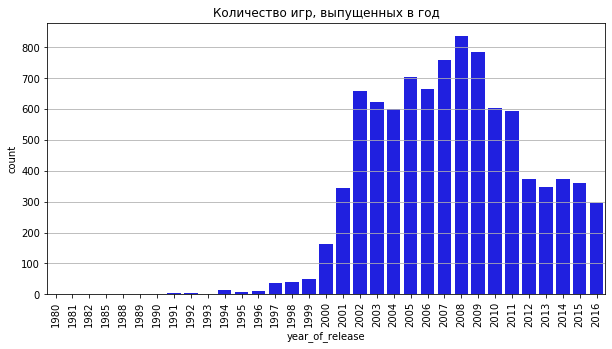

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=games, x='year_of_release', ax=ax, color='blue')
plt.xticks(rotation=90)
plt.title('Количество игр, выпущенных в год')
plt.grid(axis='y')
plt.show()

#### Вывод

Видим, что выпуск игр начал расти с 1994 года. Пиковым годом по количеству, выпущенных игр, являются 2008-2009 года. После произошел резкий спад в индустрии игр. Данные за период 1980-1993 не так важны, так как в этот период направление игр не было сильно развито, поэтому данные по этим играм мало какую информацию могут дать. Также рынок был не таким большим и компьютеры как и другие платформы были только на стадии развития для персонального пользования.

### Как менялись продажи по платформам

Возьмем первые 10 платформ по количеству продаж.

In [58]:
platform_sales = games.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
platform_sales.reset_index(inplace=True)
platform_sales_top = platform_sales.sort_values(by='sum_sales', ascending=False)
platform_sales_top = platform_sales_top.iloc[:15,:]
platform_sales_top

,platform,sum_sales
12,PS2,1048.809937
21,X360,904.700012
13,PS3,849.169983
19,Wii,749.500000
3,DS,487.769989
14,PS4,264.329987
11,PS,263.980011
22,XB,230.330002
10,PC,215.479996
15,PSP,212.000000


In [59]:
platform_top = platform_sales_top['platform'].tolist() # получим список платформ, на которых сумма продаж была наибольшей
platform_top

['PS2',
 'X360',
 'PS3',
 'Wii',
 'DS',
 'PS4',
 'PS',
 'XB',
 'PC',
 'PSP',
 'GBA',
 'GC',
 '3DS',
 'XOne',
 'WiiU']

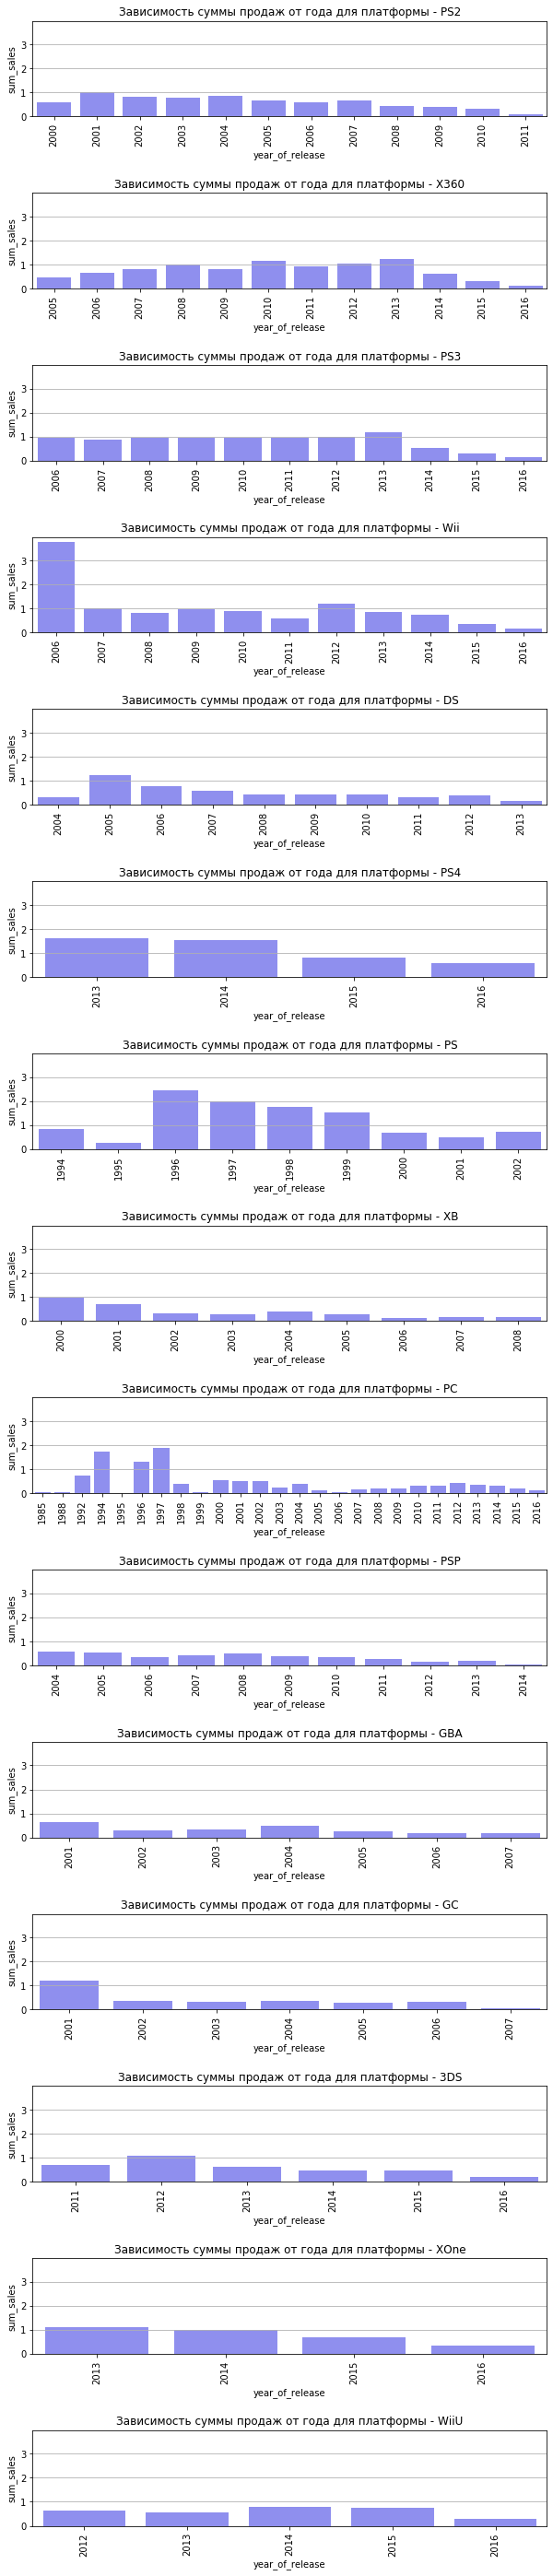

In [60]:
fig, ax = plt.subplots(ncols=1, nrows=len(platform_top), figsize=(10, 50), sharey=True)
for platform in range(len(platform_top)):
    name_platform = platform_top[platform]
    sns.barplot(data=games.query('platform == @name_platform'), x='year_of_release', y='sum_sales', ax=ax[platform], ci=0, color='blue', alpha=0.5)
    ax[platform].set_title(f'Зависимость суммы продаж от года для платформы - {platform_top[platform]}')
    ax[platform].tick_params(labelrotation=90, axis='x')
    ax[platform].grid(axis='y')

plt.subplots_adjust(wspace=0, hspace=0.8)
plt.show()

У платформы Wii в 2006 году было продаж на сумму около 3 миллиардов долларов. На самом ли деле?

In [61]:
games.query('year_of_release == 2006 and platform == "Wii"').sort_values(by='sum_sales', ascending=False).head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
7,Wii Play,Wii,2006,Misc,13.960000,9.180000,2.93,2.84,58.0,6.6,E,28.910000
107,The Legend of Zelda: Twilight Princess,Wii,2006,Action,3.740000,2.140000,0.60,0.68,95.0,9.0,T,7.160000
503,WarioWare: Smooth Moves,Wii,2006,Puzzle,0.860000,1.040000,0.73,0.26,83.0,7.4,E10+,2.890000
717,Super Monkey Ball: Banana Blitz,Wii,2006,Misc,1.050000,0.910000,0.04,0.24,74.0,5.7,E,2.240000


Похоже на правду...

Скажем, что платформа исживает себя тогда, когда перестают идти продажи игр. Посчитаем то, сколько времени каждая из платформ пользовалась спросом.
- PS2: 11 лет (2000-2011)
- X360: 11 лет (2005-настоящее время)
- PS3: 10 лет (2006-настоящее время)
- Wii: 10 лет (2006-настоящее время)
- DS: 9 лет (2004-2013)
- PS: 9 лет (1994-2003)
- GBA: 7 лет (2000-2007)
- PS4: 4 года (2013-настоящее время)
- PSP: 11 лет (2004-2015)
- PC: 23 года (1992-настоящее время). Не берем в расчет 1985 и 1988 года
- 3DS: 6 лет (2011-настоящее время)
- XB: 9 лет (2000-2008)
- GC: 7 лет (2001-2007)
- N64: 7 лет (1996-2002)
- XOne: 4 года (2013-настоящее время)

Посмотрим последовательно на разницу лет между появлением платформ на рынке:
1. PC (1992) - PS (1994): 2 года
2. PS (1994) - GBA (2000) и PS2 (2000): 6 лет
3. GBA (2000) и PS2 (2000) - DS (2004) и PSP (2004): 4 года
4. DS (2004) и PSP (2004) - X360 (2005): 1 год
5. X360 (2005) - PS3 (2006) и Wii (2006): 1 год
6. Wii (2006) - PS4 (2013): 7 лет

#### Вывод

В среднем платформе требуется 10 лет (7-11 лет), чтобы "исчезнуть", и в среднем 4 (1-7 лет) года для того, чтобы появились новые платформы.

### Актуальный период

Определим актуальный период, который позволит сделать прогноз на 2017 год. Для анализа возьмем такой период, в течение которого точно присутствуют платформы, спрос на которые по-прежнему востребован в настоящее время, рынок игр развит. Возьмем период от 2005 до 2016 года.

In [62]:
games_old = games.copy()

In [63]:
games = games.query('year_of_release >= 2005')
games.shape

(6694, 12)

Количество данных сократилось на 37.5% относительно первоначального объема.

### Потенциально прибыльные платформы

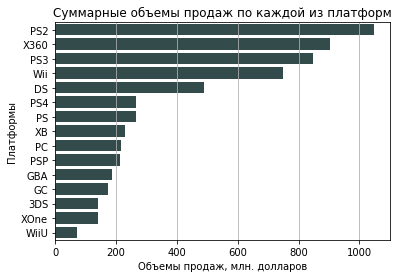

In [64]:
sns.barplot(data=platform_sales_top, y='platform', x='sum_sales', orient='h', color='darkslategrey')
plt.title('Суммарные объемы продаж по каждой из платформ')
plt.xlabel('Объемы продаж, млн. долларов')
plt.ylabel('Платформы')
plt.grid(axis='x')
plt.show()

Платформы PS2, X360, PS3, Wii, DS, PS лидируют по продажам.

Отвечая на вопрос, какие платформы подают и растут, нужно знать конкретный период, за который рассматриваем. Платформы, которые пользуются спросом сейчас и которые имеют наибольшее число продаж, следующие: X360, PS3, Wii, PS4, PC, 3DS, XOne. Рассмотрим, как ведут себя продажи по этим платформам, чтобы определить какие платформы потенциально прибыльные. Для этого построим сводную таблицу с медианными суммами продаж в разные года. Это нужно для того, чтобы при построении графиков, недостаток, связанный с разным балансом данных в разные года ушел.

In [65]:
platform_now = ['X360', 'PS3', 'Wii', 'PS4', 'PC', '3DS', 'XOne']
data_platform_now = games.query('platform in @platform_now')
mean_sales_platform_now = data_platform_now.pivot_table(index=['platform', 'year_of_release'], values='sum_sales', aggfunc='mean')
mean_sales_platform_now.reset_index(inplace=True)

mean_sales_platform_now.fillna(0, inplace=True)

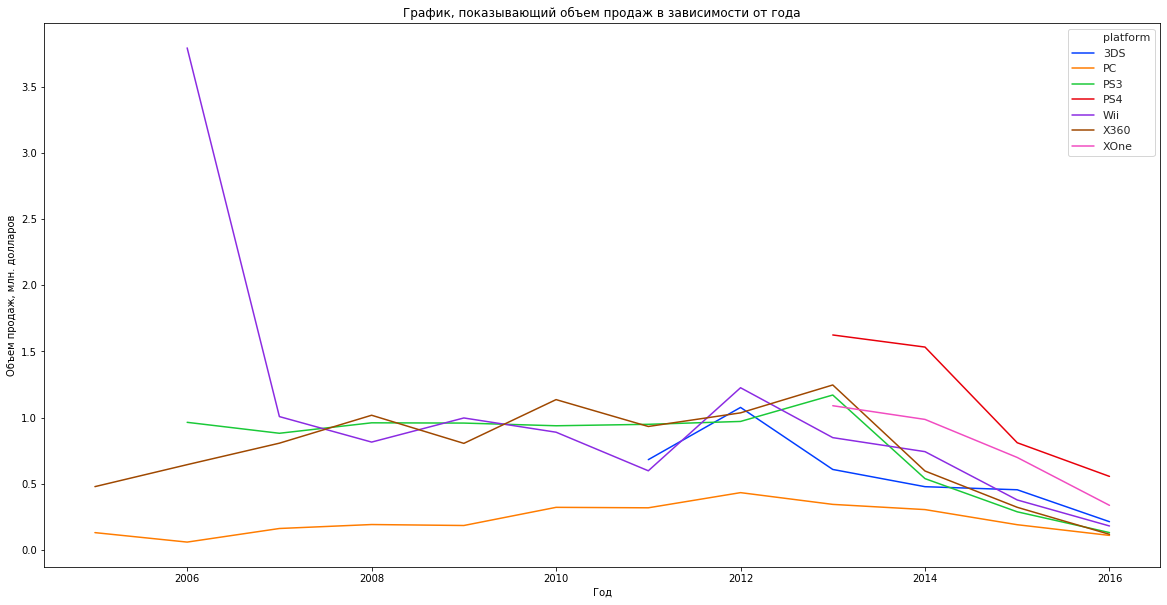

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='whitegrid')
sns.lineplot(data=mean_sales_platform_now, x='year_of_release', y='sum_sales', hue='platform', ci=None, palette='bright')
plt.title('График, показывающий объем продаж в зависимости от года')
plt.xlabel('Год')
plt.ylabel('Объем продаж, млн. долларов')
plt.show()

Получаем, что потенциально прибыльными платформами можно назвать 3DS, наблюдаем небольшой рост продаж в период 2015-2016, PS4, так как хоть и видим спад продаж, но при этом он наибольший относительно продаж других платформ. На втором по продажам в конце 2016 года - XOne. Продажи игр на платформе PC можно предположить, что будут всегда стабильно на одном уровне. По платформам PS3, X360 и Wii наблюдаем резки спад в продажах.

#### Вывод

Потенциально прибыльными платформами являются 3DS, PS4, XOne и PC.

### График «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.

In [67]:
games = pd.concat([games, games_without_year]) # присоединяю массив данных, в которых пропущен год
games = games.query('year_of_release >= 2005')

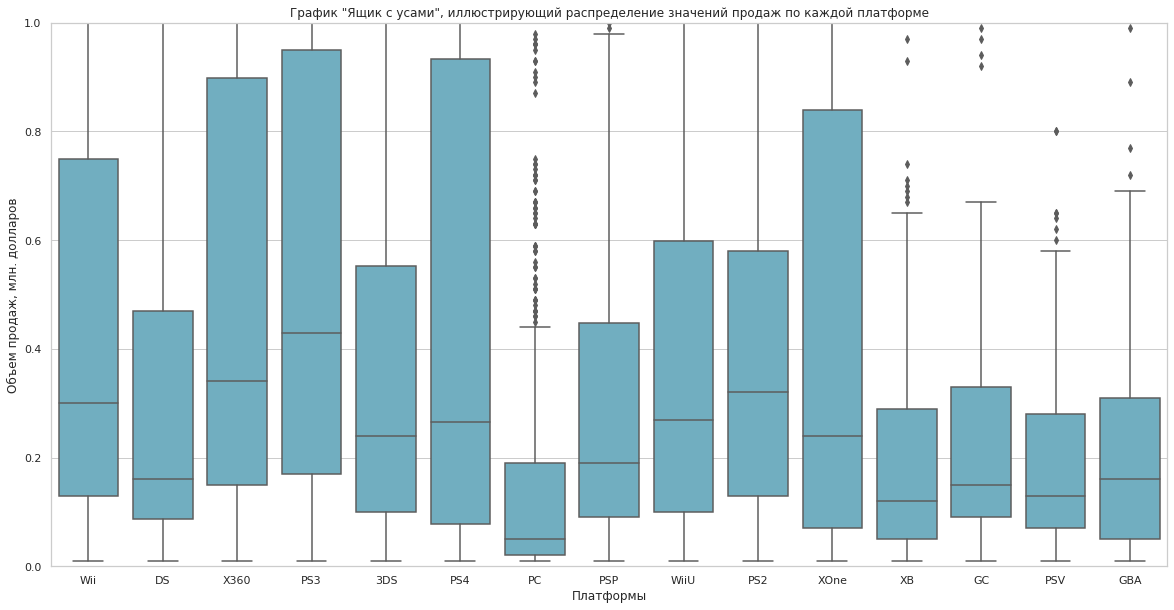

In [68]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='whitegrid')
sns.boxplot(data=games, x='platform', y='sum_sales', ax=ax, color='c')
plt.ylim(0, 1)
plt.title('График "Ящик с усами", иллюстрирующий распределение значений продаж по каждой платформе')
plt.ylabel('Объем продаж, млн. долларов')
plt.xlabel('Платформы')
plt.show()

Делая вывод о различиях в продаж между платформами, можно выделить похожие распредления ящиков с усами в отдельные группы, показав разницу между ними (при сравнении групп выбросы не берем в расчет):
- Первая группа: X360, PS3, PS4 и XOne 

Большинство продаж в данной группе достигает значения от 0.1 до 0.8 млн. долларов. Медианное значение находится на уровне выше 0.2-0.3 млн. долларов. Платформы PS3 и PS4 изготовлены одним и тем же производителем как и у платформ XOne и X360.
- Вторая группа: Wii, WiiU и PS2 

Большинство продаж в данной группе достигает значения от 0.1 до 0.5 млн. долларов. Медианное значение находится на уровне выше 0.2 млн. долларов. Платформы Wii и WiiU изготовлены одним и тем же производителем.
- Третья группа: DS, 3DS, GBA, XB и GC 

Большинство продаж в данной группе достигает значения от 0.05 до 0.3 млн. долларов. Медианное значение находится на уровне выше 0.1 млн. долларов. Платформы DS и 3DS изготовлены одним и тем же производителем.
- Четвертая группа: PC, PSP, PSV и DC

Большинство продаж в данной группе достигает значения от 0 до 0.2 млн. долларов. Медианное значение находится на уровне выше 0.05 млн. долларов. Платформы Wii и WiiU изготовлены одним и тем же производителем.

In [69]:
mean_sales = games.pivot_table(index='platform', values='sum_sales', aggfunc='mean')
mean_sales.reset_index(inplace=True)
mean_sales.sort_values(by='sum_sales')

,platform,sum_sales
9,PSV,0.224734
4,PC,0.236078
2,GBA,0.238219
13,XB,0.239422
3,GC,0.293419
8,PSP,0.397452
5,PS2,0.570462
1,DS,0.582200
11,WiiU,0.627105
0,3DS,0.649953


Средние продажи разделим по границам (млн. долларов):
- больше 70: PS3, X360 и PS4
- 50-70: 3DS, WiiU, Wii и XOne
- 30-50: DS и PS2
- 20-30: PC, GBA, PSP, XB и GC
- 0-20: DC и PSV

#### Вывод

Платформами с наибольшими продажами являются X360, PS3, PS4, XOne, Wii и WiiU.  
Также востребованные, но пользующиеся меньшим спрос по сравнению с группой выше: 3DS, DS и PS2.  
Платформы с наименьшими продажами PC, PSP, GBA, XB, GC, DC и PSV.

### Влияние отзывов пользовталей и критиков на продажи внутри одной популярной платформы

Рассмотрим платформу PS3.

Посмотрим на то, как оценка пользователей и критиков соотносится между собой.

In [70]:
data_ps3 = games.query('platform == "PS3"')
data_ps3.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.049999
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.789999


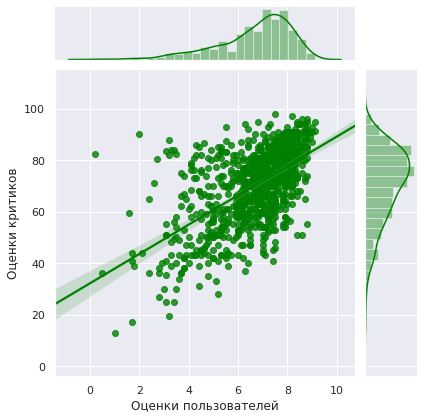

In [71]:
sns.set(style='darkgrid')
sns.jointplot(data=data_ps3, x='user_score', y='critic_score', color='green', kind='reg')
plt.xlabel('Оценки пользователей')
plt.ylabel('Оценки критиков')
plt.show()

Заметен тренд и корреляция между оценками, однако говорить, что оценки повторяют друг друга нельзя.

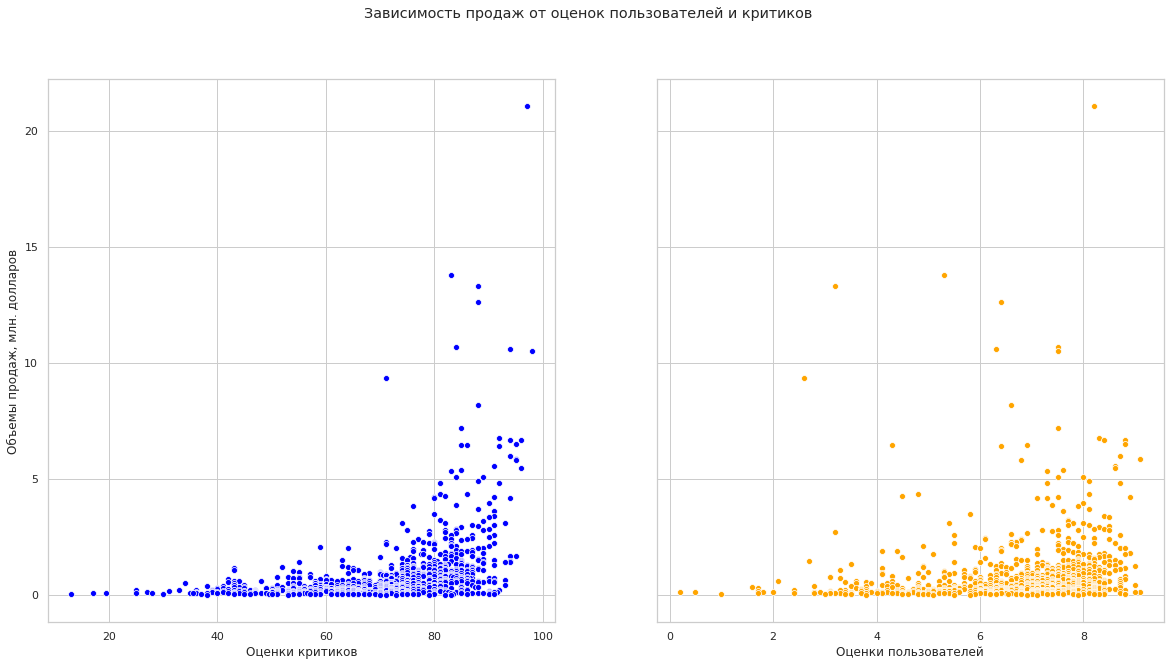

In [72]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)
sns.scatterplot(data=data_ps3, x='critic_score', y='sum_sales', color='blue', ax=ax[0])
sns.scatterplot(data=data_ps3, x='user_score', y='sum_sales', color='orange', ax=ax[1])
ax[0].set_ylabel('Объемы продаж, млн. долларов')
ax[0].set_xlabel('Оценки критиков')
ax[1].set_xlabel('Оценки пользователей')
fig.suptitle('Зависимость продаж от оценок пользователей и критиков')
plt.show()

In [73]:
print(f"Корреляция между оценками критиков и продажами составляет: {data_ps3['sum_sales'].corr(data_ps3['critic_score'])}")
print(f"Корреляция между оценками пользователей и продажами составляет: {data_ps3['sum_sales'].corr(data_ps3['user_score'])}")

Корреляция между оценками критиков и продажами составляет: 0.4055296074347686
Корреляция между оценками пользователей и продажами составляет: 0.1359793953775695


#### Вывод

На продажи больше всего влияет оценка критиков, что логично. Корреляция между продажами и оценкой критиков примерно в 3 раза больше, чем корреляция между продажами и оценкой пользователей.

### Справедлив ли вывод из пункта выше для других платформ?

In [74]:
platforms = games['platform'].unique().tolist()
for platform in platforms:
    corr_sales_user = games['sum_sales'].corr(games.query('platform == @platform')['user_score'])
    corr_sales_critic = games['sum_sales'].corr(games.query('platform == @platform')['critic_score'])
    print(f'Корреляция оценок пользователей и продаж - {corr_sales_user}')
    print(f'Корреляция оценок критиков и продаж - {corr_sales_critic}')
    if games['sum_sales'].corr(games.query('platform == @platform')['critic_score']) > games['sum_sales'].corr(games.query('platform == @platform')['user_score']):
        print(f'Вывод для платформы {platform} верен!')
        print()
    else:
        print(f'Вывод для платформы {platform} не верен!')
        print()
    

Корреляция оценок пользователей и продаж - 0.12565572323165386
Корреляция оценок критиков и продаж - 0.16015540760047178
Вывод для платформы Wii верен!

Корреляция оценок пользователей и продаж - 0.16864216389435913
Корреляция оценок критиков и продаж - 0.22173923280480518
Вывод для платформы DS верен!

Корреляция оценок пользователей и продаж - 0.12328238626323126
Корреляция оценок критиков и продаж - 0.37778377280988756
Вывод для платформы X360 верен!

Корреляция оценок пользователей и продаж - 0.1359793953775695
Корреляция оценок критиков и продаж - 0.4055296074347686
Вывод для платформы PS3 верен!

Корреляция оценок пользователей и продаж - 0.24138649354008063
Корреляция оценок критиков и продаж - 0.3217095081942238
Вывод для платформы 3DS верен!

Корреляция оценок пользователей и продаж - -0.01954829317422885
Корреляция оценок критиков и продаж - 0.38703249094672143
Вывод для платформы PS4 верен!

Корреляция оценок пользователей и продаж - -0.02782240116971445
Корреляция оценок кр

Данный вывод верен и для других платформ кроме WiiU и GC.

### Распределение игр и продаж по жанрам

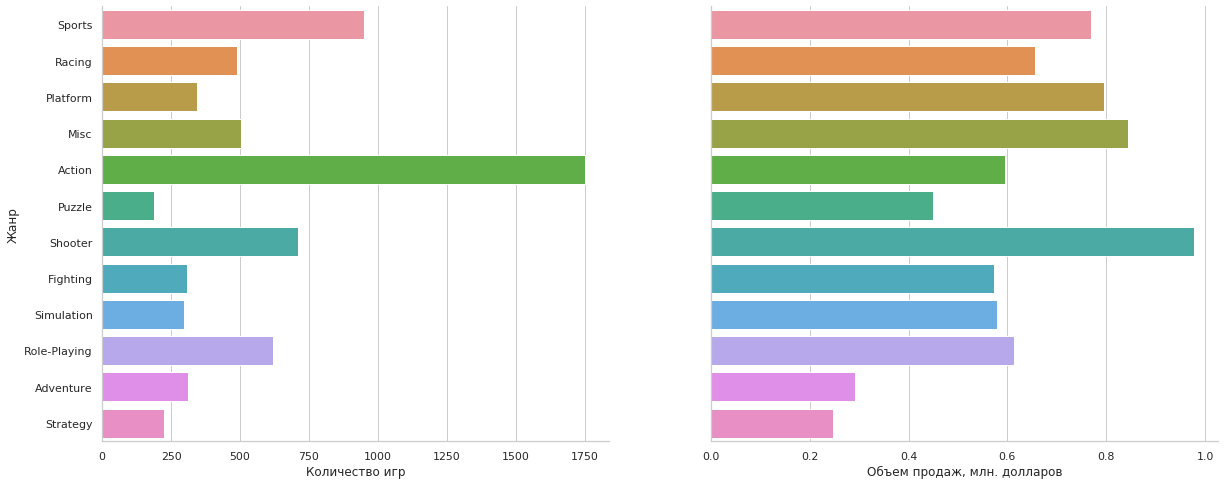

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.set_style('whitegrid')
sns.countplot(data=games, y='genre', ax=ax[0])
sns.barplot(data=games, y='genre', x='sum_sales', ax=ax[1], ci=None)
ax[0].set_ylabel('Жанр')
ax[0].set_xlabel('Количество игр')
ax[1].set_xlabel('Объем продаж, млн. долларов')
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
sns.despine()
plt.show()

Больше всего игр произведено в жанре Action (более 2500). Второе место по количеству делят жанры Sports и Misc (около 1400). Третье место - Role-playing и Adventure (около 1000). Меньше всего их сделано в жанрах Puzzle, Platform, Fighting, Strategy (менее 500).

Больше всего продаж принесли жанры Shooter (более 0.9), Platform (0.7) и Sports (около 0.6). Данные жанры можем отнести к прибыльным. Жанрами с низким объемом продаж являются Puzzle, Adventure и Strategy (менее 0.3). К жанрам со "средним" объем продаж относятся все остальные.

#### Вывод

Больше всего игр сделано в жанре Action, Role-Playing и Adventure, а продаются лучше всего жанры Shooter, PLatform и Sports. Интересно отметить, что игр в жанре Platform меньше всего относительно других жанров при этом данный жанр является лидером продаж.

## Портрет пользователя каждого региона

### Портреты

Для каждого пользователя региона нужно понять следующее:
- самые популярные платформы (топ-5);
- cамые популярные жанры (топ-5).

In [76]:
regions = {'na_sales': 'Северной Америки', 'eu_sales': 'Европы', 'jp_sales': 'Японии'}
col_regions = list(regions.keys())

region_platform_sales = games.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
region_genre_sales = games.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

region_platform_sales.reset_index(inplace=True)
region_genre_sales.reset_index(inplace=True)

cols = ['na_sales', 'eu_sales', 'jp_sales']
for col in cols:
    region_platform_sales[col] = region_platform_sales[col] / region_platform_sales[col].sum()
    region_genre_sales[col] = region_genre_sales[col] / region_genre_sales[col].sum()

print(region_platform_sales.head(5))
print()
print(region_genre_sales.head(5))

  platform  eu_sales  jp_sales  na_sales
0      3DS  0.027865  0.115158  0.024223
1       DS  0.089756  0.258625  0.106129
2      GBA  0.003062  0.004688  0.005089
3       GC  0.004863  0.005830  0.011156
4       PC  0.069488  0.000000  0.019443

       genre  eu_sales  jp_sales  na_sales
0     Action  0.248061  0.176584  0.230840
1  Adventure  0.021333  0.018933  0.020299
2   Fighting  0.030679  0.050126  0.042356
3       Misc  0.088634  0.086909  0.103048
4   Platform  0.056904  0.099110  0.060764


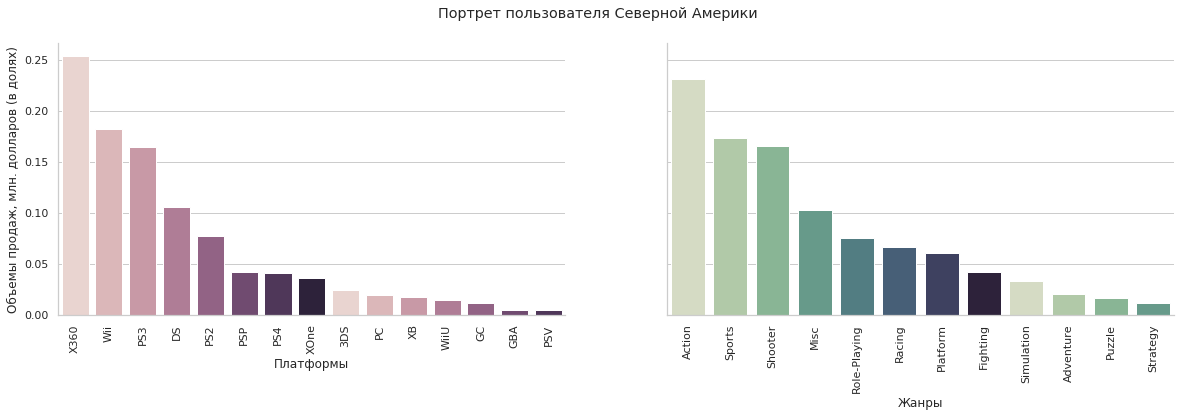

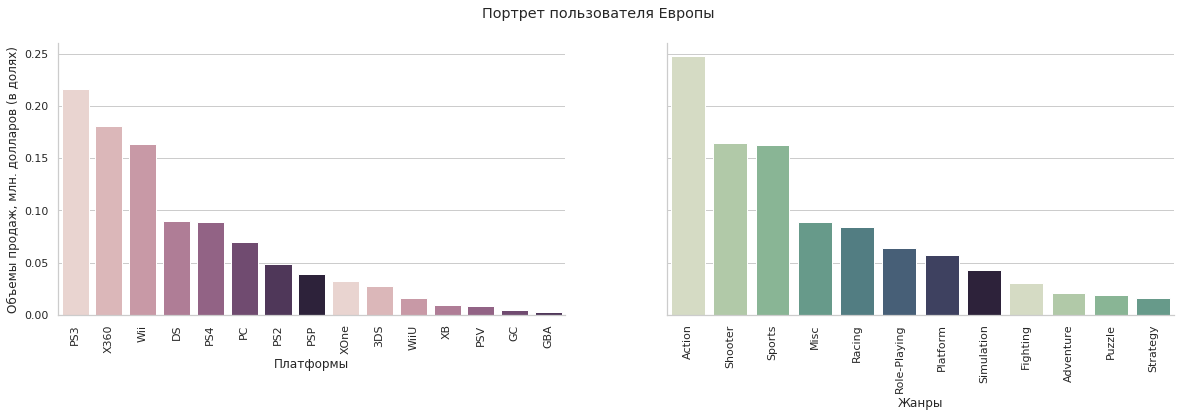

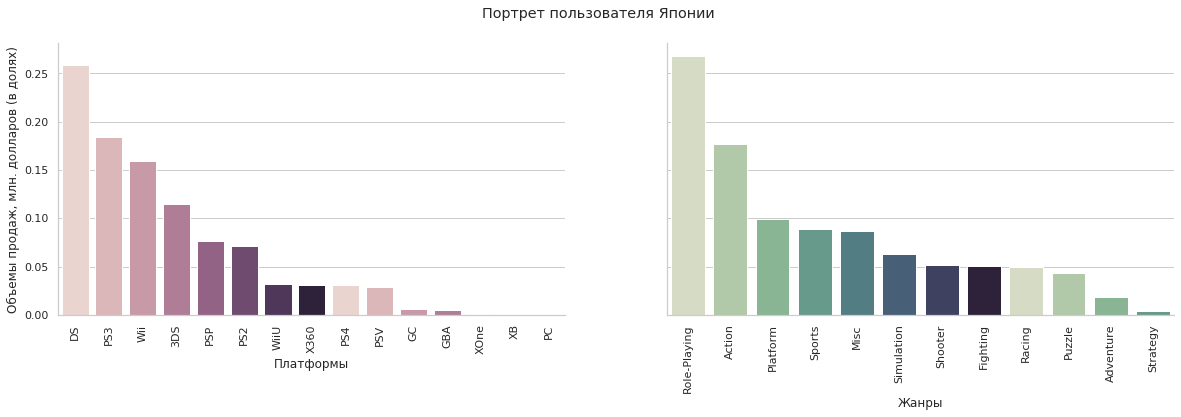

In [77]:
for region in range(len(col_regions)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)
    fig.suptitle(f'Портрет пользователя {regions[col_regions[region]]}')
    sns.barplot(data=region_platform_sales.sort_values(by=col_regions[region], ascending=False), x='platform', y=col_regions[region], ax=ax[0], ci=None, palette=sns.cubehelix_palette(8))
    sns.barplot(data=region_genre_sales.sort_values(by=col_regions[region], ascending=False), x='genre', y=col_regions[region], ax=ax[1], ci=None, palette=sns.cubehelix_palette(8, start=.5, rot=-.75))
    ax[0].set_xlabel('Платформы')
    ax[1].set_xlabel('Жанры')
    ax[0].set_ylabel('Объемы продаж, млн. долларов (в долях)')
    ax[1].set_ylabel('')
    ax[0].tick_params(labelrotation=90, axis='x')
    ax[1].tick_params(labelrotation=90, axis='x')
    sns.despine()
plt.show()

- Портрет пользователя Северной Америки:
    - Топ-5 популярных платформ: 1-X360, 2-Wii, 3-PS3, 4-DS, 5-PS2;
    - Топ-5 популярных жанров: 1-Action, 2-Sports, 3-Shooter, 4-Misc, 5-Racing.

- Портрет пользователя Европы:
    - Топ-5 популярных платформ: 1-PS3, 2-X360, 3-Wii, 4-DS, 5-PS4;
    - Топ-5 популярных жанров: 1-Action, 2-Sports, 3-Shooter, 4-Misc, 5-Platform.
    
- Портрет пользователя Японии:
    - Топ-5 популярных платформ: 1-DS, 2-3DS, 3-PS3, 4-PSP, 5-Wii;
    - Топ-5 популярных жанров: 1-Role-Playing, 2-Action, 3-Misc, 4-Sports, 5-Platform.

#### Вывод

Для пользоватей Северной Америки характерны платформы X360, PS3, Wii, DS как и для пользоватлей Европы. Разница в соотношении долей, так в Северной Америке процент от продаж игр на платформе X360 составляет более 20%, когда в Европе он составляет около 15%. В Еропе больший объем продаж приносит платформа PS3 (около 20%). В сравнении с Северной Америкой процент по этой платформе составляет в районе 15%. В Японии, наоборот такие платформы пользуются меньшей популярность, так объем продаж игр на платформе X360 сотавляет менее 5% от общих продах, а на платформе PS3 около 12%. В Японии больше популярность пользуются такие платформы как DS и 3DS. Эти платформы вместе приносят более 40% объемов продаж (DS - примерно 28%, а 3DS - 16%). В Северной Америке и Европе платформа 3DS популрность не пользуется, приносит менее 5% продаж.

В Северной Америке и Европе вкусы пользователей почти не различаются. Пользователи выбирают больше такие жанры как Action, Sports, Shooter и Misc. Напротив, в Японии предпочтения игроков по жанрам отличаются. Так, на первом месте стоят игры в жанре Role-Playing, затем идут игры в жанре Action, Misc и Sports.

### Влияние рейтинга ESRB на продажи в регионах

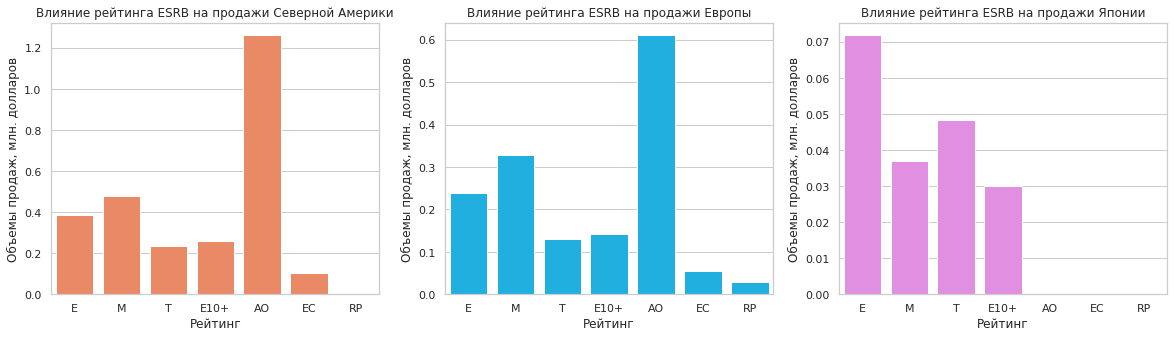

In [78]:
colors = ['coral', 'deepskyblue', 'violet']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for region in range(len(col_regions)):
    sns.barplot(data=games, x='rating', y=col_regions[region], ax=ax[region], ci=None, color=colors[region])
    ax[region].set_xlabel('Рейтинг')
    ax[region].set_ylabel('Объемы продаж, млн. долларов')
    ax[region].set_title(f'Влияние рейтинга ESRB на продажи {regions[col_regions[region]]}')
plt.show()

#### Вывод

В Северной Америке как и Европе больше всего продаж приносят игры с рейтингом AO и M, это игры категории для взрослых. Меньше всего в этих двух регионах приносят продаж игры с категорией EC и T, это игры для детей от 3 лет и подростков от 13 лет. Ситуация в Японии обстоит иначе, здесь нет игр с рейтингом AO и EC, больше всего продаж приходятся на игры с рейтингом T и E.

## Проверка гипотез

Заранее зададим уровень значимости, равный 5%.

In [79]:
alpha = .05

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Данная гипотеза относится к гипотезе о равенстве средних двух генеральных совокупностей. 

In [80]:
xone_user_score = games.loc[games['platform'] == 'XOne', 'user_score']
pc_user_score = games.loc[games['platform'] == 'PC', 'user_score']

H0: средние пользовательские оценки у платформ Xbox One и PC равны  
H1: -//- не равны

In [81]:
result = st.ttest_ind(xone_user_score, pc_user_score)
print(f'p-value: {result.pvalue}')
if result.pvalue >= alpha:
    print('Не отвергаем гипотезу')
else:
    print('Отвергаем гипотезу')

p-value: 0.022648373803310133
Отвергаем гипотезу


Отвергаем гипотезу. С очень низкой вероятность можем получить различие средних оценок случайно.

### Средние пользовательские рейтинги жанров Action и Sports разные

Данная гипотеза относится к гипотезе о равенстве средних двух генеральных совокупностей. 

In [82]:
action_user_score = games.loc[games['genre'] == 'Action', 'user_score']
sports_user_score = games.loc[games['genre'] == 'Sports', 'user_score']

H0: средние пользовательские оценки у жанров ACtion и Sports равны  
H1: -//- не равны

In [83]:
result = st.ttest_ind(action_user_score, sports_user_score)
print(f'p-value: {result.pvalue}')
if result.pvalue >= alpha:
    print('Не отвергаем гипотезу')
else:
    print('Отвергаем гипотезу')

p-value: 1.0568691132193693e-11
Отвергаем гипотезу


Отвергаем гипотезу. С очень низкой вероятность можем получить различие средних оценок случайно.

## Общий вывод

Целью данного проекта было выявить определяющие успешность игры закономерности. Понять, на какие игры нужно сделать основной упор при планировании рекламной капмании.

Проведя аналитику данных выше, получаем, что берем период с 2005 по 2016 года.
Важно рассматривать такие платформы, которые пользуются популярность и спросом в текущий момент. К таким платформам относятся: X360, PS3, Wii, PS4, PC, 3DS, XOne.  

При планировании рекламной кампании основной упор стоит сделать на игры, которые идут на платформах 3DS, PS4, XOne. Данные платформы потенциально прибыльные по сравнению с платформами PS3, X360 и Wii, на которые спрос постепенно падает уже в течение нескольких лет. Стабильной по продажам платформой является PC, который тоже стоит включить группу, на которую нужно выделить больше денежных средств при рекламе.  

Однако большинство наибольших продаж приносят такие платформы как X360, PS3, PS4 и XOne, которые достигают велечины до 0.8 млн. долларов, а медианное значение продаж у платформ в такой группе составляет 0.2-0.3 млн. долларов, что выше по сравнению с другими платформами.  

При принятии решения о том, какие игры и на каких платформах рекламировать, важно брать во внимание оценку критиков. Корреляция между оценкой критиков и продажми существенная в районе 40%.  

Помимо оценки критиков на продажи на них также влиеят жанр игр. Жанрами, пользующимися наибольшим спросом являются Shooter, Platform и Sports. Именно на игры с этим жанром нужно выделить большую долю рекламных средств.  

Продумывая стратегию кампании, важно ее дифференцировать для разных групп людей. Выводы выше справедливы для всех в среднем. Однако стоит направить внимание на специфику регионов. Так в регионах Северной Америки и Европы большим спросом пользуются такие платформы как X360, PS3, Wii и DS, а в Японии DS, 3DS и PS3. Хоть мы и сделали вывод, что наблюдается тенденция к падению продаж по данным платформам кроме 3DS, не стоит все равно о них забывать, выделив разную долю денежных средств для каждой платформы в зависимости от региона и того, какую долю продаж она приносит в этом регионе. Вкусы пользователей в Северной Америке и Европе по жанрам не отличаются. Пользователи предпочитают игры в стиле Aсtion, Sports и Shooter, в то время как пользователям из Японии больше нравятся жанры Role-Playing, Action и Misc. Поэтому стоит обрать внимание и на специфические вкусы регионов по жанрам и платформам при разделении реклам. Большим спросом пользуются игры для взрослых в Северной Америке и Европе, когда в Японии игры с рейтингом ESRB для подростков.

Дополнительно были проверены две гипотезы, результаты которых следующие:
- Средние оценки пользователей по платформам Xbox One и PC не равны;
- Средние оценки пользователей по жанрам Action и Sports также не равны.